# Выбор локации для скважины

Заказчик проекта добывающая компания «ГлавРосГосНефть». 
Нужно принять решение о разработке скважин в одном из трех регионов на основании предоставленных характеристик. 

Для этого необходимо проанализировать три датасета geo_data_0, geo_data_1 и geo_data_2. 

План работ:
1. Загрузка и предобработка данных
    * Проверим консистентность данных 
    * Проверим наличие выбросов в данных
    * Проверим данные на мультиколлениарность
2. Обучение и проверка модели
    * Построим модель линейной регргессии и проанализруем ее метрики
3. Подготовка к расчету прибыли
    * Подготовим бизнес показатели
4. Расчет прибыли и рисков
    * Рассчитаем бизнес показатели для 200 лучших скважин из произвольной выборки в 500 скважин
    * Применим технику Bootstrap для определения бизнес показателей, 95% доверительного интервала и расчета рисков

## 1. Загрузка и предобработка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from numpy.random import RandomState
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты на месте

In [3]:
data_0 = pd.read_csv('geo_data_0.csv')
data_0.name = 'Первый регион'
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
data_1 = pd.read_csv('geo_data_1.csv')
data_1.name = 'Второй регион'
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
data_2 = pd.read_csv('geo_data_2.csv')
data_2.name = 'Третий регион'
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
#создадим список с названиями датафреймов для последующего использования
data_list = [data_0, data_1, data_2]

In [7]:
#удалим незначимый столбец id 
for data in data_list:
    data = data.drop(['id'], axis=1)

1  Регион:


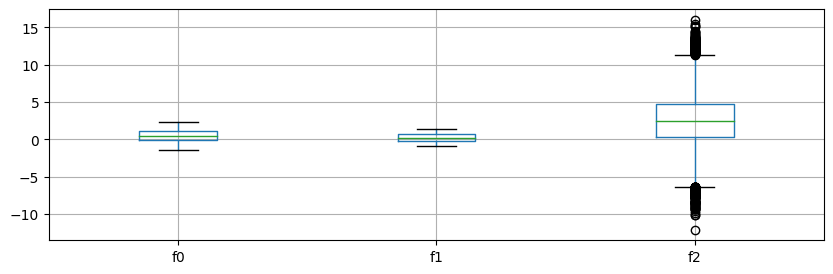

2  Регион:


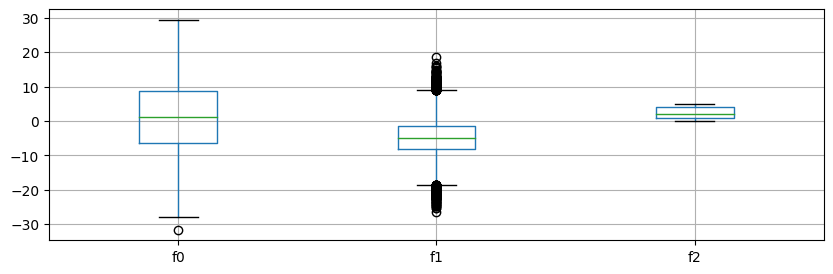

3  Регион:


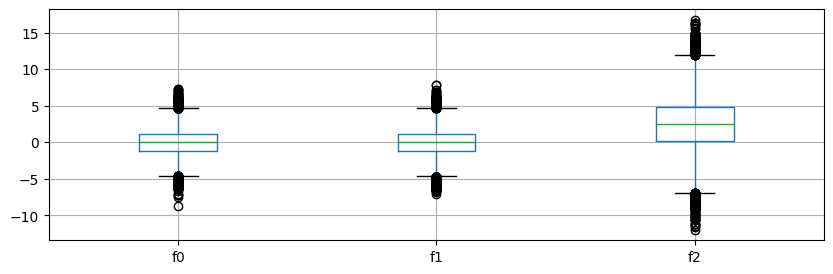

In [8]:

#Проверим данные на наличие выбросов
i = 1
for data in data_list:
    data.boxplot(column=['f0','f1', 'f2'], figsize=(10, 3))
    print(i, ' Регион:')
    plt.show()
    i += 1

In [9]:
#Соберем данные о выбросах в справочник
data_to_clean = [(data_0,"f2"),
                 (data_1,"f1"),
                 (data_2,"f0"),
                 (data_2,"f1"),
                 (data_2,"f2")]

In [10]:
#Напишем функцию для удаления выбросов на основе справочника
def clean_data(frame,column):
    q25=np.array(frame[column].quantile(0.25))
    q75=np.array(frame[column].quantile(0.75))
    Q1=q25-1.5*(q75-q25)
    Q3=q75+1.5*(q75-q25)
    del_index = []
    for index_value, value in zip(frame[column].index,frame[column]):
        if Q3 <= value or value <= Q1:
            del_index.append(index_value)
    
    print('To drop: ',len(del_index))
    return del_index

In [11]:
for frame,column in data_to_clean:
    indexes = clean_data(frame,column)
    frame.drop(indexes,axis = 0,inplace = True)

To drop:  506
To drop:  636
To drop:  733
To drop:  682
To drop:  582


1  Регион:


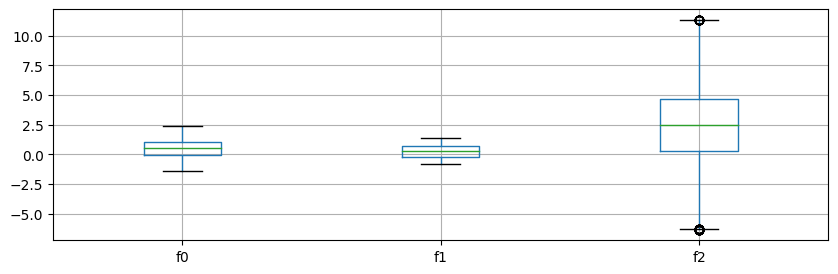

2  Регион:


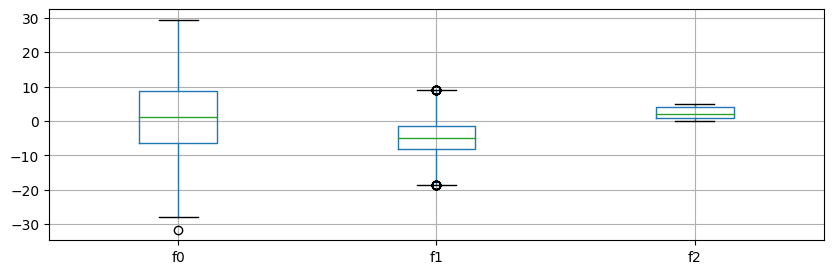

3  Регион:


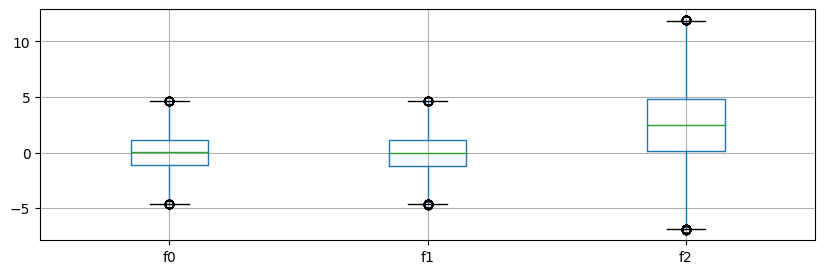

In [12]:
#Еще раз построим графики для проверки выбросов
i = 1
for data in data_list:
    data.boxplot(column=['f0','f1', 'f2'], figsize=(10, 3))
    print(i, ' Регион:')
    plt.show()
    i += 1

In [13]:
#Проверим данные на мультиколлениарность
i = 1
for data in data_list:
    print(i, ' Регион:', '\n', 
          data.corr(), '\n')
    i +=1

1  Регион: 
                f0        f1        f2   product
f0       1.000000 -0.440716 -0.003339  0.143591
f1      -0.440716  1.000000  0.001098 -0.192748
f2      -0.003339  0.001098  1.000000  0.480159
product  0.143591 -0.192748  0.480159  1.000000 

2  Регион: 
                f0        f1        f2   product
f0       1.000000  0.178877 -0.001670 -0.030389
f1       0.178877  1.000000 -0.002756 -0.010174
f2      -0.001670 -0.002756  1.000000  0.999397
product -0.030389 -0.010174  0.999397  1.000000 

3  Регион: 
                f0        f1        f2   product
f0       1.000000  0.000649  0.000473 -0.002962
f1       0.000649  1.000000  0.000710 -0.000895
f2       0.000473  0.000710  1.000000  0.441211
product -0.002962 -0.000895  0.441211  1.000000 



Можем заметить что в данных 2 Региона присутствует сильная корреляция признаков f2 и целевого признака, для последующего анализа корреляция с целевым признаком нам не помешает.

## 2. Обучение и проверка модели

In [14]:
#Подготовим выборки
feature_names = ['f0', 'f1', 'f2']
target_name = ['product']

X_0 = data_0[feature_names]
y_0 = data_0[target_name]

X_1 = data_1[feature_names]
y_1 = data_1[target_name]

X_2 = data_2[feature_names]
y_2 = data_2[target_name]

In [15]:
def model_fit_valid(X, y):
    """
    Функция разделяет данные на обучающую и валидационную выборки 75/25
    обучает модель LinearRegression 
    делает предсказания на валидационной выборке
    выводит среднее значение предсказаний и RMSE
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)
    print('Train shape:', X_train.shape)
    print('Valid shape:', X_valid.shape)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    predict = model.predict(X_valid)

    predict_mean = predict.mean()
    rmse = mean_squared_error(y_valid, predict)**.5

    print('Cредний запас предсказанного сырья: {:.4f}'.format(predict_mean))
    print('RMSE: {:.4f}'.format(rmse))
    
    return y_valid, predict

In [16]:
print('1 Регион:')
y_0_valid, predict_0 = model_fit_valid(X_0, y_0)

1 Регион:
Train shape: (74620, 3)
Valid shape: (24874, 3)
Cредний запас предсказанного сырья: 92.3505
RMSE: 37.8151


In [17]:
print('2 Регион:')
y_1_valid, predict_1 = model_fit_valid(X_1, y_1)

2 Регион:
Train shape: (74523, 3)
Valid shape: (24841, 3)
Cредний запас предсказанного сырья: 68.5495
RMSE: 0.8911


In [18]:
print('3 Регион:')
y_2_valid, predict_2 = model_fit_valid(X_2, y_2)

3 Регион:
Train shape: (73502, 3)
Valid shape: (24501, 3)
Cредний запас предсказанного сырья: 94.9518
RMSE: 40.1296


## Выводы ##

- Для регионов 1 и 3 средний объем сырья на основании предсказаний модели **92.4** и **94.95** соответственно. Однако величина среднеквадратичной ошибки для этих регионо достаточно высока **37.8** и **40.1** соответственно, что может говорить о несовершенности построенной модели. 

- В регионе 2 средний показатель запаса составляет **68.5** , что ниже остальных регионов. Однако величина ошибки крайне мала **0.9**. Вероятнее всего данные расчеты более точные.

## 3. Подготовка к расчёту прибыли

In [19]:
BUDGET = 10**10 #общий бюджет
TOP_WELLS = 200 #выборка 200 скважин
SAMP_WELLS = 500 #общая выборка 500 скважин
UNIT_INCOME = 4.5*10**5 #доход на скважину

<div class="alert alert-block alert-success">
<b>Успех:</b> Лайк за константы в верхнем регистре!
</div>

In [20]:
DOT = BUDGET / (TOP_WELLS * UNIT_INCOME)
print('Точка безубыточности для одной скважины: {:.2f}'.format(DOT))

Точка безубыточности для одной скважины: 111.11


In [21]:
print('Средний запас нефти на скважину по регионам:')
print('1 Регион:', data_0['product'].mean())
print('2 Регион:', data_1['product'].mean())
print('3 Регион:', data_2['product'].mean())

Средний запас нефти на скважину по регионам:
1 Регион: 92.50067661514835
2 Регион: 68.80991858101544
3 Регион: 94.78507187440762


## Выводы ##

Точка безубыточности для одной скважины составляет **111.1**. 

Данное значение превышает средние значения запасов скважин по всем регионам (на основании исходных данных | предсказанное моделью ):
* Первый регион: 92.5 | 92.4
* Второй регион: 68.8 | 68.5
* Третий регион: 94.8 | 94.95

## 4. Расчёт прибыли и рисков 

In [22]:
y_0_valid = pd.Series(y_0_valid['product']).reset_index(drop=True)
y_1_valid = pd.Series(y_1_valid['product']).reset_index(drop=True)
y_2_valid = pd.Series(y_2_valid['product']).reset_index(drop=True)

In [23]:
predict_0 = pd.Series(*predict_0.reshape(1,-1))
predict_1 = pd.Series(*predict_1.reshape(1,-1))
predict_2 = pd.Series(*predict_2.reshape(1,-1))

In [24]:
def show_predicted_income(region, top_wells_mean, volume, income):
    print(region)
    print('Средний запас сырья среди скважин с максимальным показателем: {:.2f}'.format(top_wells_mean))
    print('Суммарный целевой объём сырья: {:.2f}'.format(volume))
    print('Прибыль для полученного объёма сырья: {:.2f}'.format(income))

In [25]:
state = 12
def predicted_income(target, predicts, region, state, replace=False, show_res=True, return_res=False):
    """
    Функция берет выборку из 500 скважин и выбирает из них 200 лучших
    считает среднее значение объёма сырья для выбранных скважин, суммарный целевой объём сырья, прибыль для полученного объёма сырья
    """
    sample_preds = predicts.sample(n=SAMP_WELLS, 
                                   replace=replace, 
                                   random_state=state)
    top_preds = sample_preds.sort_values(ascending=False)[:TOP_WELLS]
    top_targets = target[top_preds.index]
    top_wells_mean = top_targets.mean()
    volume = sum(top_targets)
    income = volume * UNIT_INCOME - BUDGET
    if show_res:
        show_predicted_income(region, top_wells_mean, volume, income)
    if return_res:
        return income

In [26]:
predicted_income(y_0_valid, predict_0, '1 Регион:', state)

1 Регион:
Средний запас сырья среди скважин с максимальным показателем: 117.01
Суммарный целевой объём сырья: 23401.13
Прибыль для полученного объёма сырья: 530506869.56


In [27]:
predicted_income(y_1_valid, predict_1, '2 Регион:', state)

2 Регион:
Средний запас сырья среди скважин с максимальным показателем: 112.70
Суммарный целевой объём сырья: 22540.11
Прибыль для полученного объёма сырья: 143051191.39


In [28]:
predicted_income(y_2_valid, predict_2, '3 Регион:', state)

3 Регион:
Средний запас сырья среди скважин с максимальным показателем: 108.50
Суммарный целевой объём сырья: 21700.19
Прибыль для полученного объёма сырья: -234916127.75


In [29]:
def show_risks(region, income_mean, conf_int_left, conf_int_right, loss_rate):
    print(region)
    print('Средняя прибыль {:.2f} (млн. Р)'.format(income_mean / 10**6))
    print('95% доверительный интервал: {:.2f} : {:.2f} (млн. Р)'.format(conf_int_left / 10**6, conf_int_right / 10**6))
    print('Риск убытков: {:.2f} %'.format(loss_rate * 100))

In [30]:
def risk_calc(target, predicts, region):
    """
    bootstrap (1000 выборок)
    Функция берет выборку из 500 скважин и выбирает из них 200 лучших
    считает общую прибыль income_pred и сохраняет её в списке incomes.
    выводит:  Среднюю прибыль
              95% доверительный интервал
              Риск убытков 
    """
    bootstrap_samples = 1000
    alpha = 0.05
    incomes = []
    state = np.random.RandomState(12)
    for _ in range(bootstrap_samples):
        income = predicted_income(target, predicts, region, state, replace=True, show_res=False, return_res=True)
        incomes.append(income)

    incomes = pd.Series(incomes)
    income_mean = incomes.mean()
    conf_int_left = incomes.quantile(alpha/2)
    conf_int_right = incomes.quantile(1 - alpha/2)
    
    loss_count = 0
    for inc in incomes :
        if inc < 0 :
            loss_count += 1
    loss_rate = loss_count / bootstrap_samples
    #loss_rate = stats.percentileofscore(incomes, 0)
    
    show_risks(region, income_mean, conf_int_left, conf_int_right, loss_rate)

In [31]:
risk_calc(y_0_valid, predict_0, 'Регион 1:')

Регион 1:
Средняя прибыль 401.10 (млн. Р)
95% доверительный интервал: -120.90 : 906.50 (млн. Р)
Риск убытков: 6.30 %


In [32]:
risk_calc(y_1_valid, predict_1, 'Регион 2:')

Регион 2:
Средняя прибыль 439.62 (млн. Р)
95% доверительный интервал: 44.60 : 862.99 (млн. Р)
Риск убытков: 1.30 %


In [33]:
risk_calc(y_2_valid, predict_2, 'Регион 3:')

Регион 3:
Средняя прибыль 386.23 (млн. Р)
95% доверительный интервал: -128.11 : 890.75 (млн. Р)
Риск убытков: 7.60 %


## Выводы ##
- При расчёте показателей для 200 наилучших скважин из 500 в выборке:
    - Средний запас сырья с одной скважины по регионам:
        * 1 Регион - **117**
        * 2 Регион - **112.7**
        * 3 Регион - **108.5** 
    
    что больше точки безубыточности равной **111.11** для всех регионов кроме 3-его региона. 

- После применения bootstrap:
    - Оценка средней прибыли максимальна для 2 Региона (**439.62 млн.**).
    - Только 2 Регион прогнозирует положительную прибыль в 95% доверительном интервале.
    - Риск убытков для 2 Региона (**1.3%**)

На основании полученных данных можно рекомендовать ***2 Регион*** для разработки месторождений.

## Общие выводы ##

* Нам были предоставлены три датасета **geo_data_0, geo_data_1 и geo_data_2**
Была проведена **предобработка данных** устранены выбросы и удалены незначимые признаки, также данные были проверены на мультиколлениарность.

* Мы обучили модель **линейной регрессии** и проанализировали среднюю величину целевого признака и величину среднекватратической ошибки. 
Результаты предварительной оценки показали, что 1 и 3 регионы показывают наибольшие средние запасы, но имеют достаточно высокий показатель ошибки, что говорит о неточности прогнозирования, с другой стороны **2 регион показал меньшие средние запасы** по целевому признаку, но **модель была более точная** с меньшим значением ошибки. 

* На основании условий, которы были получены от заказчика мы **рассчитали точку безубыточности** для одной скважины (**111.11**) и сравнили ее с величиной прогнозируемых запасов на одну скважину по регионам, которые оказались меньше необходимой величины точки безубыточности. 

* Также мы выбрали **200 скважин** с максимальными значениями предсказаний из произвольной **выборки в 500 скважин** для каждого региона.
Просуммировали целевое значение объёма сырья, соответствующее этим предсказаниям. Рассчитали прибыль для полученного объёма сырья.

* После чего применили технику **Bootstrap** с 1000 выборок, чтобы найти **среднюю прибыль**, **95%-й доверительный интервал** и **риск убытков**.

* На основании полученных результатов **наиболее перспективным оказался второй регион** (geo_data_1) который показал наибольшую среднюю прибыль в **439.62 млн.** с наименьшей вероятностью убытка в **1.3%**. 

